In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils

import matplotlib.pyplot as plt
import numpy as np
import random
import math

import os

In [2]:


batch_size =64
workers = 2
epochs = 100

latent_size=100

gf_dim = 64
df_dim = 64

in_h = 128
in_w = 128
c_dim = 1

n_critic = 5 # the number of iterations of the critic per generator iteration

learning_rate = 0.0001
beta1=0.5
beta2=0.9

gp_lambda = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

manualSeed = 3734
print("Random Seed: ",manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  3734


In [3]:
transform = transforms.Compose(
    [
     transforms.Resize((in_h,in_w)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
     ]
)
def transform_inverse (y):
  t= None
  if y.size()[0]==1:#1-dim
    t=torchvision.transforms.Normalize((-1,),(2,))
  else :#3-dim
    t=torchvision.transforms.Normalize((-1,-1,-1),(2,2,2))
  return t(y)

def batch_transform_inverse(y):
  x = y.new(*y.size())
  if y.size()[1]==1:
    x[:, 0, :, :] = y[:, 0, :, :] * 2 - 1
  else:
    x[:, 0, :, :] = y[:, 0, :, :] * 2 - 1
    x[:, 1, :, :] = y[:, 1, :, :] * 2 - 1
    x[:, 2, :, :] = y[:, 2, :, :] * 2 - 1
  return x

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from PIL import Image


class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_size=(64, 64)):
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size
        self.image_filenames = [filename for filename in os.listdir(root_dir) if filename.endswith('.png')]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_filenames[idx])
        image = Image.open(img_name)
        #image = image.resize(self.target_size, Image.LANCZOS)  # Resize image with LANCZOS filter
        if self.transform:
            image = self.transform(image)
        return image


# Define constants
IMAGE_SIZE = (64, 64)
IMAGE_DIR = './experimental'

# Transformation to convert images to PyTorch tensors
transform = transforms.Compose([
    transforms.Resize((in_h,in_w)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# Create dataset
dataset = CustomDataset(root_dir=IMAGE_DIR, transform=transform)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


torch.Size([64, 1, 128, 128])


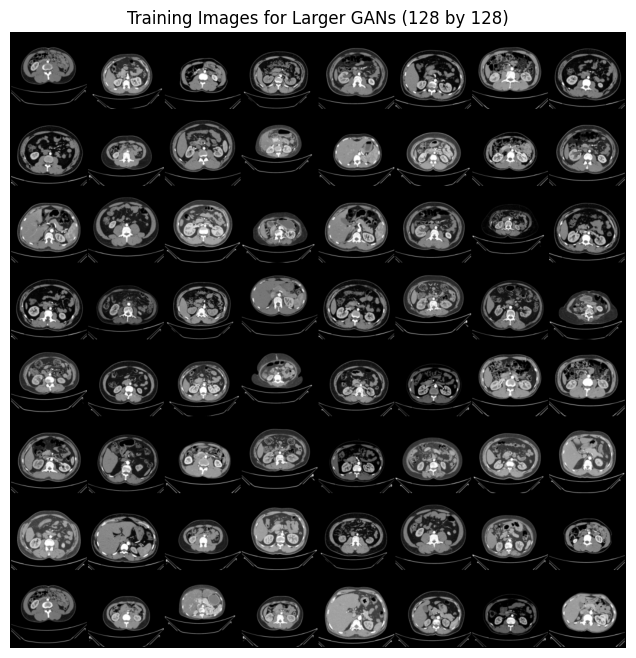

In [5]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis('off')
plt.title('Training Images for Larger GANs (128 by 128)')
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device),padding=2, normalize=True).cpu(),(1,2,0)))

print(real_batch.size())

In [6]:
import torch.nn as nn

def conv_bn_layer(in_channels,out_channels,kernel_size,stride=1,padding=0):
    return nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size,stride=stride,padding=padding,bias=False),
        nn.BatchNorm2d(out_channels,momentum=0.1,eps=1e-5),
    )
def tconv_bn_layer(in_channels,out_channels,kernel_size,stride=1,padding=0):
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride=stride,padding=padding,bias=False),
      nn.BatchNorm2d(out_channels,momentum=0.1,eps=1e-5),
  )
def tconv_layer(in_channels,out_channels,kernel_size,stride=1,padding=0):
  return nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride=stride,padding=padding)

def conv_layer(in_channels,out_channels,kernel_size,stride=1,padding=0):
    return nn.Conv2d(in_channels,out_channels,kernel_size,stride=stride,padding=padding)

def fc_layer(in_features,out_features):
  return nn.Linear(in_features,out_features)

def fc_bn_layer(in_features,out_features):
  return nn.Sequential(
      nn.Linear(in_features,out_features,bias=False),
      nn.BatchNorm1d(out_features)
  )

In [7]:
def conv_out_size_same(size, stride):
  return int(math.ceil(float(size) / float(stride)))
s_h, s_w = in_h, in_w
s_h2, s_w2 = conv_out_size_same(s_h, 2), conv_out_size_same(s_w, 2)
s_h4, s_w4 = conv_out_size_same(s_h2, 2), conv_out_size_same(s_w2, 2)
s_h8, s_w8 = conv_out_size_same(s_h4, 2), conv_out_size_same(s_w4, 2)
s_h16, s_w16 = conv_out_size_same(s_h8, 2), conv_out_size_same(s_w8, 2)
s_h32, s_w32 = conv_out_size_same(s_h16, 2), conv_out_size_same(s_w16, 2)
print(s_h32, s_w32)

4 4


In [8]:
import torch.nn as nn
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.fc_bn_layer1 = fc_bn_layer(latent_size, s_h32*s_w32*gf_dim*8) # Initial fully connected layer
        self.up_sample_layer2 = tconv_bn_layer(gf_dim*8, gf_dim*4, 4, stride=2, padding=1) # Upsample to 16x16
        self.up_sample_layer3 = tconv_bn_layer(gf_dim*4, gf_dim*2, 4, stride=2, padding=1) # Upsample to 32x32
        self.up_sample_layer4 = tconv_bn_layer(gf_dim*2, gf_dim, 4, stride=2, padding=1)   # Upsample to 64x64
        self.up_sample_layer5 = tconv_bn_layer(gf_dim, gf_dim//2, 4, stride=2, padding=1)  # Upsample to 128x128
        self.up_sample_layer6 = tconv_layer(gf_dim//2, c_dim, 4, stride=2, padding=1)      # Final convolutional layer
        ## 
        self.tanh = nn.Tanh()
        self.gaussian_kernel = nn.Parameter(torch.randn(gf_dim * 8, gf_dim * 8, 3, 3))  # Corrected input channels

        ## channels 
        self.adjust_channels2 = nn.Conv2d(gf_dim * 8, gf_dim * 4, kernel_size=1)
        self.adjust_channels3 = nn.Conv2d(gf_dim * 4, gf_dim * 2, kernel_size=1)
        self.adjust_channels4 = nn.Conv2d(gf_dim * 2, gf_dim, kernel_size=1)
        self.adjust_channels5 = nn.Conv2d(gf_dim, gf_dim // 2, kernel_size=1)
        self.adjust_channels6 =  nn.Conv2d(gf_dim // 2, c_dim, kernel_size=1)

        ## 
        self.ac3 = nn.Conv2d(gf_dim*8,gf_dim*2,kernel_size=1)
        ## 
        self.ac4 = nn.Conv2d(gf_dim*4, gf_dim, kernel_size=1)
        self.ac5 = nn.Conv2d(gf_dim * 2, gf_dim // 2, kernel_size=1)
        self.ac6 = nn.Conv2d(gf_dim,1,1)

    def forward(self, x):
        x1 = self.fc_bn_layer1(x).view(-1, gf_dim * 8, s_h32, s_w32) # Reshape after fully connected layer
        x1 = F.conv2d(x1, self.gaussian_kernel, padding=1)
        x2 = F.relu(self.up_sample_layer2(x1))
        x3 = F.relu(self.up_sample_layer3(x2))
        x4 = F.relu(self.up_sample_layer4(x3))
        x5 = F.relu(self.up_sample_layer5(x4))
        x6 = F.relu(self.up_sample_layer6(x5)) # Upsample to 128x128

        ## 
        
        x2_skip = F.interpolate(x1, scale_factor = 2, mode='nearest')
        x2_skip = self.adjust_channels2(x2_skip)
        x2 = torch.add(x2,x2_skip)
        x2 = torch.add(x2,x2_skip)
        
    #   64, 128, 16, 16
        #x3_random_noise = self.softplus(torch.randn(x3.size(),device=device))
        x3_skip = F.interpolate(x2, scale_factor = 2, mode='nearest')
        x3_skip = self.adjust_channels3(x3_skip)

   
        x3 = torch.add(x3,x3_skip)
        x3 = torch.add(x3,x3_skip)


        ## dropout x3

        x4_skip = F.interpolate(x3, scale_factor = 2, mode='nearest')
        x4_skip = self.adjust_channels4(x4_skip)
        
        x4 = torch.add(x4,x4_skip)
        x4 = torch.add(x4,x4_skip)
        
        
        x5_skip =F.interpolate(x4, scale_factor = 2, mode='nearest')
        x5_skip = self.adjust_channels5(x5_skip)

      

        x5 = torch.add(x5,x5_skip)
        x5 = torch.add(x5,x5_skip)
   

        x6_skip =F.interpolate(x5, scale_factor = 2, mode='nearest')
        x6_skip = self.adjust_channels6(x6_skip)

      

        x6 = torch.add(x6,x6_skip)  
    
      
        return self.tanh(x6)



In [9]:
"""
batch normalization changes the form of the discriminator's problem from mapping a single input to a single output to mapping from an entire batch of inputs to a batch of outputs.
Since we penalize the norm of the critic's gradient with respect to each input independently, and not the entire batch, our penalized training objective is no longer valid in this setting.
"""
class Critic(nn.Module):
  def __init__(self):
    super(Critic,self).__init__()
    self.down_sample_layer1 = conv_layer(c_dim,df_dim // 2,4,stride=2,padding=1)
    self.down_sample_layer2 = conv_layer(df_dim // 2,df_dim,4,stride=2,padding=1)
    self.down_sample_layer3 = conv_layer(df_dim,df_dim*2,4,stride=2,padding=1)
    self.down_sample_layer4 = conv_layer(df_dim*2,df_dim*4,4,stride=2,padding=1)
    self.down_sample_layer5 = conv_layer(df_dim*4, df_dim*8, 4,stride=2, padding=1)
    self.fc_layer5 = fc_layer(df_dim*8*s_h32*s_w32,1)


  def forward(self, x):
    x = F.leaky_relu(self.down_sample_layer1(x),0.2)
    x = F.leaky_relu(self.down_sample_layer2(x),0.2)
    x = F.leaky_relu(self.down_sample_layer3(x),0.2)
    x = F.leaky_relu(self.down_sample_layer4(x),0.2)
    x = F.leaky_relu(self.down_sample_layer5(x),0.2)
    x = x.flatten(1)
    x = self.fc_layer5(x)
    return x

In [10]:
import torch.optim as optim

G = Generator().to(device)
fw = Critic().to(device)

G_optimizer = optim.Adam(G.parameters(),lr=learning_rate,betas=(beta1,beta2))
critic_optimizer = optim.Adam(fw.parameters(),lr=learning_rate,betas=(beta1,beta2))

L2_criterion = nn.MSELoss()

fixed_noise = torch.randn(batch_size, latent_size,device=device)

def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv')!=-1:
    nn.init.normal_(m.weight.data,0.0,0.02)
  elif classname.find('Norm')!=-1:
    nn.init.normal_(m.weight.data,1.0,0.02)

print(G.apply(weights_init))
print(fw.apply(weights_init))

Generator(
  (fc_bn_layer1): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=False)
    (1): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (up_sample_layer2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (up_sample_layer3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (up_sample_layer4): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (up_sample_layer5): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=F

In [12]:
import torch.optim as optim

G =  torch.load('wgan_128/wgan-kernel-9000.pth', map_location=torch.device('cuda'))
fw = torch.load('wgan_128/critic-kernel-9000.pth', map_location=torch.device('cuda'))

G_optimizer = optim.Adam(G.parameters(),lr=learning_rate,betas=(beta1,beta2))
critic_optimizer = optim.Adam(fw.parameters(),lr=learning_rate,betas=(beta1,beta2))

L2_criterion = nn.MSELoss()

fixed_noise = torch.randn(batch_size, latent_size,device=device)

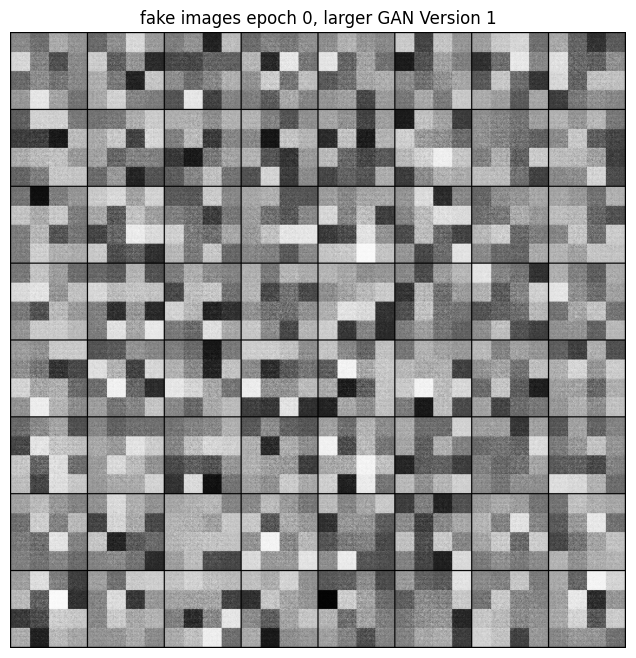

In [11]:
fixed_noise = torch.randn(batch_size, latent_size,device=device)
with torch.no_grad():
  fake_batch=G(fixed_noise)
plt.figure(figsize=(8,8))
plt.axis('off')
plt.title('fake images epoch 0, larger GAN Version 1')
plt.imshow(np.transpose(vutils.make_grid(fake_batch.to(device), padding=2, normalize=True).cpu(), (1, 2, 0)))

#plt.imshow(np.transpose(vutils.make_grid(fake_batch.to(device).view(64,c_dim,in_h,in_w),padding=2, normalize=True).cpu(),(1,2,0)))

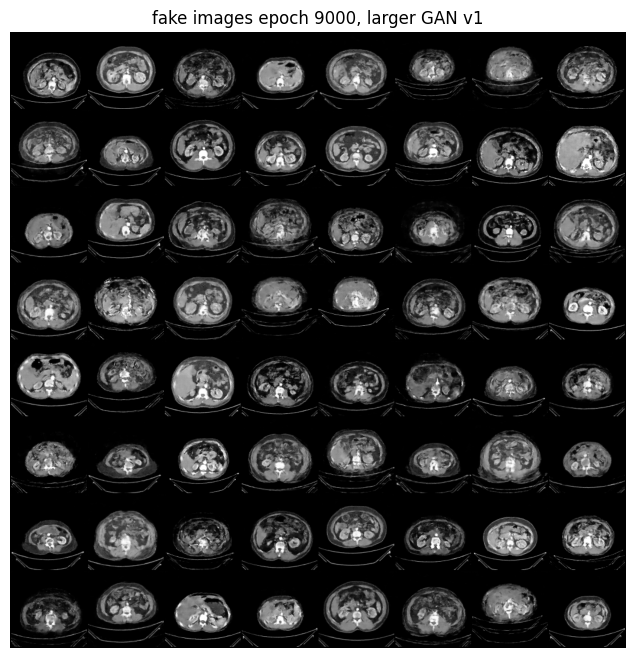

In [15]:
fixed_noise = torch.randn(batch_size, latent_size,device=device)
with torch.no_grad():
  fake_batch=G(fixed_noise)
plt.figure(figsize=(8,8))
plt.axis('off')
plt.title('fake images epoch 9000, larger GAN v1')

plt.imshow(np.transpose(vutils.make_grid(fake_batch.to(device), padding=2, normalize=True).cpu(), (1, 2, 0)))

#plt.imshow(np.transpose(vutils.make_grid(fake_batch.to(device).view(64,c_dim,in_h,in_w),padding=2, normalize=True).cpu(),(1,2,0)))

In [11]:
from scipy.stats import truncnorm
from scipy.ndimage import gaussian_filter

def get_truncated_noise(n_samples, z_dim, truncation,device):
    '''
    Function for creating truncated noise vectors: Given the dimensions (n_samples, z_dim)
    and truncation value, creates a tensor of that shape filled with random
    numbers from the truncated normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        truncation: the truncation value, a non-negative scalar
        sigma: the strength of blurring
    '''
    #### START CODE HERE ####
    truncated_noise = truncnorm.rvs(-truncation, truncation, size=(n_samples, z_dim))
    #blurred_np = gaussian_filter(truncated_noise, sigma=0.1)
    #### END CODE HERE ####
    return torch.Tensor(truncated_noise)

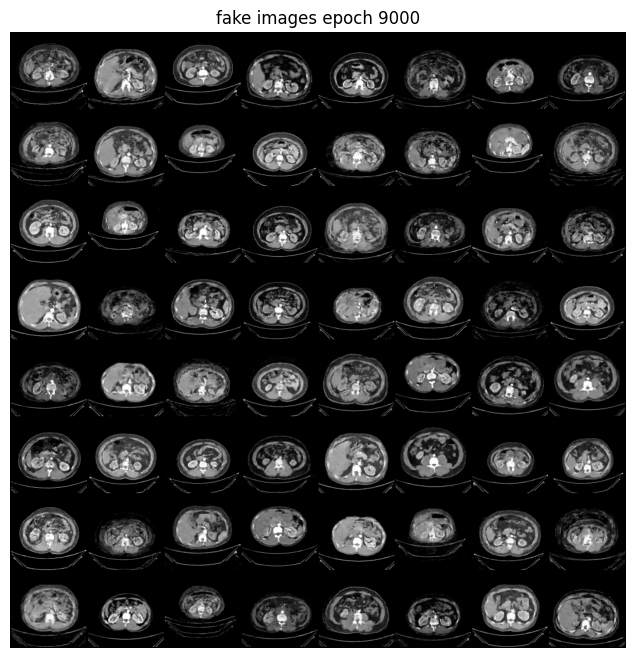

In [24]:
fixed_noise = get_truncated_noise(batch_size, latent_size, truncation=0.05, device='cuda').to(device)# torch.randn(batch_size, latent_size,device=device)
with torch.no_grad():
  fake_batch=G(fixed_noise)
plt.figure(figsize=(8,8))
plt.axis('off')
plt.title('fake images epoch 9000')

plt.imshow(np.transpose(vutils.make_grid(fake_batch.to(device), padding=2, normalize=True).cpu(), (1, 2, 0)))

#plt.imshow(np.transpose(vutils.make_grid(fake_batch.to(device).view(64,c_dim,in_h,in_w),padding=2, normalize=True).cpu(),(1,2,0)))

In [11]:
img_list = []

G_losses = []
critic_losses = []

w_losses = []
gp_losses =[]

iter_per_plot = 250
plot_per_eps=(int(len(dataloader)/iter_per_plot))

transform_PIL=transforms.ToPILImage()

In [12]:
from scipy.stats import truncnorm
from scipy.ndimage import gaussian_filter

def get_truncated_noise(n_samples, z_dim, truncation,device):
    '''
    Function for creating truncated noise vectors: Given the dimensions (n_samples, z_dim)
    and truncation value, creates a tensor of that shape filled with random
    numbers from the truncated normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        truncation: the truncation value, a non-negative scalar
        sigma: the strength of blurring
    '''
    #### START CODE HERE ####
    truncated_noise = truncnorm.rvs(-truncation, truncation, size=(n_samples, z_dim))
    #blurred_np = gaussian_filter(truncated_noise, sigma=0.1)
    #### END CODE HERE ####
    return torch.Tensor(truncated_noise)

In [13]:
import torch.autograd as autograd
from torch.autograd import Variable
import numpy as np


def save_nparr(list1, list2,epoch):
  np.save(f'wgan_128/critic_loss-{epoch}.npy', np.array(list1))
  np.save(f'wgan_128/grad_penalty-{epoch}.npy', np.array(list2))

def save_model(epoch):
  torch.save(G , f'wgan_128/wgan-kernel-{epoch}.pth')
  torch.save(fw, f'wgan_128/critic-kernel-{epoch}.pth')

cp = 250

cur_step = 0
epochs = 4000
#torch.autograd.detect_anomaly(True)

for ep in range(epochs+1):
  for real_data in dataloader:
    #print(cur_step)
    b_size=real_data.shape[0]
    real_data = real_data.to(device)

    z = torch.randn(b_size,latent_size).to(device)
    #z = get_truncated_noise(b_size, latent_size, 0.05, device).to(device)
    fake_data = G(z)

    alpha = torch.rand([b_size,1,1,1],device=device)#for sampling_distribution
    alpha = alpha.expand(real_data.size())

    #Train critic function
    fw.zero_grad()

    # calculate gradient penalty

    interpolates = alpha * real_data.data  + (1-alpha)*fake_data.data
    interpolates=Variable(interpolates,requires_grad=True)

    disc_interpolates= fw(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                                  grad_outputs=torch.ones(disc_interpolates.size(),device=device),
                                  create_graph=True)[0].view(interpolates.size(0),-1)
    slopes = gradients.norm(2,dim=1)
    lipschitz_gradient_norm=torch.ones(slopes.size(),device=device)

    loss_gp = gp_lambda*L2_criterion(slopes,lipschitz_gradient_norm)

    real_critic = fwx = fw(real_data)
    fake_critic = fwg = fw(fake_data.detach())
    loss_w = -(fwx.mean()-fwg.mean())

    loss_critic = loss_w + loss_gp
    loss_critic.backward(retain_graph=True)
    critic_optimizer.step()

    #Train G
    if (cur_step+1)%n_critic==0:
      G.zero_grad()
      fwg = fw(fake_data)

      loss_G = -fwg.mean()

      loss_G.backward()
      G_optimizer.step()

    if (cur_step+1)%iter_per_plot == 0:
      print('Epoch [{}/{}], Step [{}/{}], critic_loss: {:.4f}, g_loss: {:.4f}, fw(x): {:.4f}, fw(G(z)): {:.4f}, gp : {:.4f} '
            .format(ep, epochs, cur_step+1, len(dataloader), loss_critic.item(),  fake_critic.mean().item(),
                    real_critic.mean().item(), fake_critic.mean().item(),loss_gp.item()))
      G_losses.append(fake_critic.mean().item())
      critic_losses.append(loss_critic.item())

      w_losses.append(loss_w.item())
      gp_losses.append(loss_gp.item())



      """
      with torch.no_grad():
        G.eval()
        fake = G(fixed_noise).detach().cpu()
        #img_list.append(vutils.make_grid(torch.reshape(fake,(b_size,c_dim,in_h,in_w))[:64], padding=2, normalize=True))
        #transform_PIL(img_list[-1]).save(os.path.join('beta',str(ep)+'alpha'+"_Last.png"))
        plt.figure(figsize=(8,8))
        plt.axis('off')
        plt.title('fake Images')
        plt.imshow(np.transpose(vutils.make_grid(fake.to(device)[:64].view(64,c_dim,in_h,in_w),padding=2, normalize=True).cpu(),(1,2,0)))
        G.train()
      """
    cur_step += 1

  if ep != 0 and ep % 250 == 0:
    cp += 250
    save_model(cp)
    save_nparr(critic_losses,gp_losses, cp)

Epoch [4/4000], Step [250/52], critic_loss: -24.9465, g_loss: -33.9312, fw(x): -2.5916, fw(G(z)): -33.9312, gp : 6.3932 
Epoch [9/4000], Step [500/52], critic_loss: -23.2510, g_loss: -33.4570, fw(x): -2.8824, fw(G(z)): -33.4570, gp : 7.3236 
Epoch [14/4000], Step [750/52], critic_loss: -25.3094, g_loss: -31.9271, fw(x): -0.7507, fw(G(z)): -31.9271, gp : 5.8669 
Epoch [19/4000], Step [1000/52], critic_loss: -25.4770, g_loss: -34.3314, fw(x): -2.0793, fw(G(z)): -34.3314, gp : 6.7751 
Epoch [24/4000], Step [1250/52], critic_loss: -23.1172, g_loss: -42.3114, fw(x): -11.6180, fw(G(z)): -42.3114, gp : 7.5762 
Epoch [28/4000], Step [1500/52], critic_loss: -23.7899, g_loss: -39.5979, fw(x): -8.9127, fw(G(z)): -39.5979, gp : 6.8953 
Epoch [33/4000], Step [1750/52], critic_loss: -24.6922, g_loss: -45.2379, fw(x): -12.7228, fw(G(z)): -45.2379, gp : 7.8229 
Epoch [38/4000], Step [2000/52], critic_loss: -24.3196, g_loss: -45.0750, fw(x): -15.0605, fw(G(z)): -45.0750, gp : 5.6949 
Epoch [43/4000], S

KeyboardInterrupt: 

In [32]:
save_model(3500)
save_nparr(critic_losses,gp_losses, 3500)

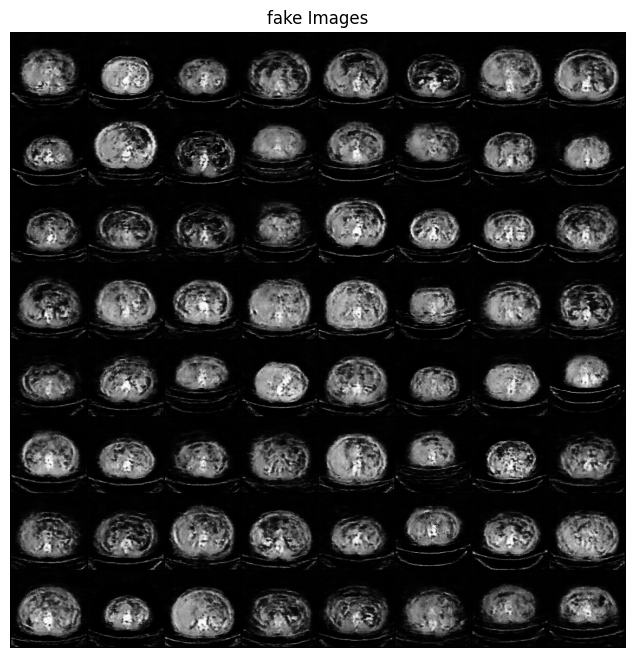

In [18]:
with torch.no_grad():
  G.eval()
  fake_batch=G(fixed_noise)
  G.train()
plt.figure(figsize=(8,8))
plt.axis('off')
plt.title('fake Images')
plt.imshow(np.transpose(vutils.make_grid(fake_batch.to(device)[:64].view(64,c_dim,in_h,in_w),padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
## THIS MODEL DOES NOT HAVE SPECTRAL NORMALIZATION ON ITS LAST LAYER
torch.save(G.state_dict(), 'models/wgan-skip-3000-state.pth')
torch.save(G , 'models/wgan-skip-3000.pth')